# preparation steps
- upload your files (model.py, min_max.yaml, mymodel.py) via the "Upload" button as a "Model". You can find it under "/kaggle/input/NAME".
- set the variable "submission_dir" to this directory
- run the cells below to test that everything is working properly, i.e., no errors, and to generate your submission: in "/kaggle/working/" appears a file called "submission.csv"
- open the tab "submit to competition" and press "submit"

In [28]:
import torch
import yaml
import sys
import numpy as np
import pandas as pd
from pathlib import Path

In [29]:
submission_dir = "./out_ml" # TODO set this to your directory

sys.path.append(submission_dir)
from mymodel import init_my_model

submission_dir = Path(submission_dir)

# Load data and model

In [30]:
# load TEST data
inputs = torch.load("kaggle_inputs.pt")
inputs = inputs.to(torch.float32)

# load SUBMITTED yaml
min_max = yaml.safe_load(open(submission_dir / "min_max.yaml", "r"))

# load SUBMITTED model
model = init_my_model()
model.load_state_dict(torch.load(submission_dir / "model.pt", map_location="cpu"))
model.eval();
# print(model)

# Rescale data

In [31]:
def rescale(data, mins_in, maxs_in, out_range=(torch.tensor([0,]), torch.tensor([1,]))):
    min_out, max_out = out_range
    return (data - mins_in[:, None, None]) / (maxs_in - mins_in)[:, None, None] * (max_out - min_out)[:, None, None] + min_out[:, None, None]

def rescale_inputs(inputs, min_max):
    inputs_mins =torch.tensor([min_max["inputs"]["u"]["min"],])
    inputs_maxs = torch.tensor([min_max["inputs"]["u"]["max"],])

    inputs_scaled = rescale(inputs, inputs_mins, inputs_maxs)
    return inputs_scaled

# norm data with min_max
inputs_scaled = rescale_inputs(inputs, min_max)

# print(inputs_scaled.min(), inputs_scaled.max())

# Infer model

In [32]:
# apply model to inputs
with torch.no_grad():
    outputs_scaled = model(inputs_scaled)

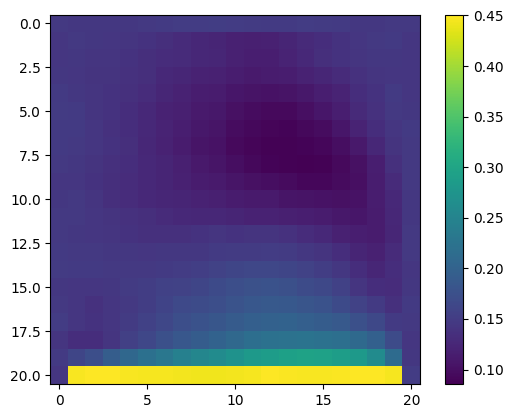

In [36]:
import matplotlib.pyplot as plt
plt.figure()
# plt.quiver(outputs_scaled[0,0].numpy(), outputs_scaled[0,1].numpy())
plt.imshow(outputs_scaled[0,0].numpy())
plt.colorbar()

# Save predictions

In [ ]:
# pd data frame with len(outputs_scale) as the number of rows and two columns: "id" and "flattened output"
rows = []

for i in range(len(inputs_scaled)):
    pred = model(inputs_scaled[i]).detach().numpy()    # (2,21,21)
    flat = pred.reshape(-1)                            # (882,)
    row = np.concatenate(([i], flat))                  # id + 882 floats
    rows.append(row)

cols = ["id"] + [f"val{j}" for j in range(2*21*21)]
df = pd.DataFrame(rows, columns=cols)

# df.to_csv("submission.csv", index=False)
